# Detectando objetos com YOLO - implementação com OpenCV

## Etapa 1 - Importando as bibliotecas

In [ ]:
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt 
from google.colab.patches import cv2_imshow
import zipfile
print(cv2.__version__)

4.1.2


## Etapa 2 - Conectando com o Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
diretorio = '/content/gdrive/My Drive/Cursos/YOLO/';

## Etapa 3 - Carregando os arquivos do modelo treinado

Vamos extrair os arquivos do modelo (.weights, yolov3.cfg e coco.names) para o diretório principal do Colab

In [ ]:
path = diretorio + "modelo_YOLO.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")

Caso você não tenha os arquivos do modelo salvos no Drive então execute o código abaixo, que irá fazer o download deles. 
**Obs: execute abaixo apenas se você não tiver esses arquivos salvos.**
 Nós recomendamos salvá-los em seu Drive pois ficará mais rápido já que não será necessário baixar os pesos da internet.

In [ ]:
# baixa o repositorio do darknet, que contém os arquivos coco.names e yolov3.cfg
!git clone https://github.com/AlexeyAB/darknet

# baixa os pesos do modelo yolo que iremos usar 
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov3.weights
# ou: https://pjreddie.com/media/files/yolov3.weights

# copia o arquivo coco.names para o diretorio principal
!cp darknet/cfg/coco.names ./

# copia o arquivo yolov3.cfg para o diretorio principal
!cp darknet/cfg/yolov3.cfg ./

Cloning into 'darknet'...
remote: Enumerating objects: 13033, done.
remote: Total 13033 (delta 0), reused 0 (delta 0), pack-reused 13033
Receiving objects: 100% (13033/13033), 11.76 MiB | 18.93 MiB/s, done.
Resolving deltas: 100% (8908/8908), done.
--2020-04-07 17:36:02--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   296KB/s    in 16m 13s 

2020-04-07 17:52:17 (249 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]



Carrega os labels (nomes) das classes do COCO dataset, que o modelo padrão do YOLO foi treinado

In [ ]:
labels_path = os.path.sep.join(['/content/', "coco.names"])
LABELS = open(labels_path).read().strip().split("\n")

Define o caminho para os pesos YOLO do modelo treinado e para o arquivo que possui as configurações do modelo

In [ ]:
weights_path = os.path.sep.join(['/content/', "yolov3.weights"])
config_path = os.path.sep.join(['/content/', "yolov3.cfg"])

Carrega do disco o arquivo com o detector YOLO treinado com o dataset COCO (80 classes)

In [ ]:
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

## Etapa 4 - Definindo mais configurações para a detecção 

Inicializa uma lista de cores aleatórias para representar cada classe possível na hora de mostrar os resultados (uma cor para cada classe, para poder diferenciar melhor)

In [ ]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

#print(COLORS)

Agora vamos obter a lista com o nome de todas as camadas da rede. Em seguida precisamos determinar os nomes das camadas de saída apenas (output layers) do modelo YOLO. 
Por que precisamos fazer isso? O modelo YOLO é treinado através do framework Darknet, conforme vimos. Precisamos fornecer explicitamente os nomes das camadas de saída na hora de chamar a função `.forward ()`, na etapa seguinte. Isso é necessário especificar ao usar os modelos Darknet com OpenCV.

In [ ]:
ln = net.getLayerNames() # obtem a lista com os nomes de todas as camadas

print("Todas as camadas (layers):")
print(ln)
print("Total: "+ str(len(ln)))

Todas as camadas (layers):
['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_3

E como saber quais os nomes dessas camadas de saída? Podemos obter o índice dessas camadas com a função `net.getUnconnectedOutLayers()`.
Com essa função obtemos o índices e não o nome diretamente, mas a partir dessa índice podemos consultar a lista que contém todas as camadas (agora armazenado na variável `ln`) e assim obter o nome

In [ ]:
print("Camadas de saída: ")
print(net.getUnconnectedOutLayers())

### Apenas para visualizar o que está sendo feito, vamos listar todas as camadas de saída com o for ### 
for i in net.getUnconnectedOutLayers():
  print(i[0]) # A variável i contém o o índice da camada na lista de todas as camadas (getLayerNames())
  # Vamos usar esse indice para indicar exatamente essas camadas que iremos manter na lista de camadas
  # Ou seja, com os indices de getUnconnectedOutLayers sabemos a posição das camadas de saída na lista
  print(ln[i[0] - 1])  # assim podemos obter o nome da camada 
  # usamos o -1 para retornar a posição correta pois o indice da lista (ln) inicia com 0. 
  # ou seja, se o número total de camadas é 254 então o ultimo indice possível é 253 

Camadas de saída: 
[[200]
 [227]
 [254]]
200
yolo_82
227
yolo_94
254
yolo_106


Pronto, agora que sabemos que todas as camadas de saída que precisamos são obtidas com a função `net.getUnconnectedOutLayers()` podemos manter apenas essas camadas com o comando abaixo

In [ ]:
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
print(ln)

['yolo_82', 'yolo_94', 'yolo_106']


## Etapa 5 - Carregando a imagem onde será feita a detecção

Vamos carregar uma imagem de teste com o comando abaixo (ou você pode arrastar a imagem e soltar no painel lateral, na aba dos arquivos)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cachorros.jpg to cachorros.jpg


Criaremos uma função para exibir a imagem no Colab

In [ ]:
def mostrar(img):
  fig = plt.gcf()
  fig.set_size_inches(16, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

Carrega a imagem e extrai a sua altura (Height) e largura (Width) em pixels

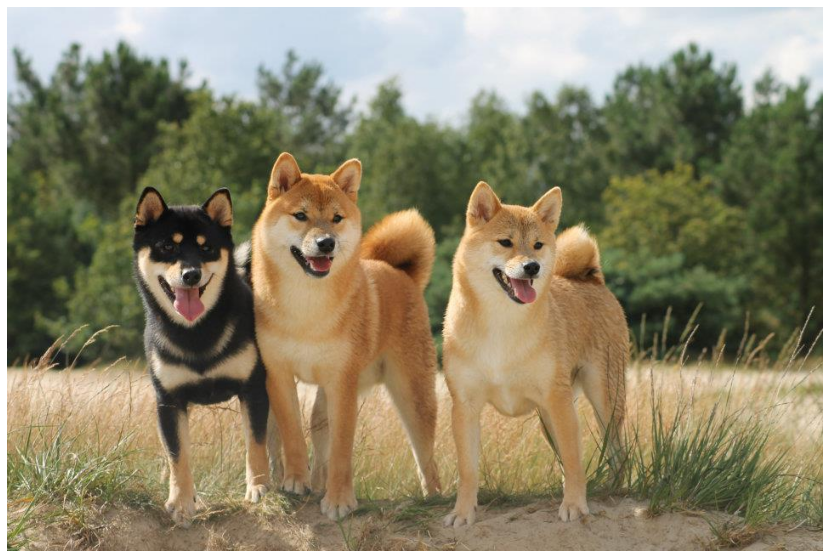

Altura: 640
Largura: 960


In [ ]:
imagem = cv2.imread("cachorros.jpg") 
mostrar(imagem) # exibe a imagem

# faremos uma cópia para ter salva a imagem original, apenas porque iremos modificá-la mais pra frente 
imagem_cp = imagem.copy() 

# extrai a altura e largura da imagem (com a função shape, que mostra a forma da matriz que corresponde à imagem)
(H, W) = imagem.shape[:2] 
# usamos o [:2] para extrair apenas os dois primeiros valores, pois não precisaremos agora do terceiro valor
# (que corresponde ao numero de canais de cores que a imagem tem, que geralmente vai ser 3: R G B)
print("Altura: " + str(H) + "\nLargura: " + str(W))

## Etapa 6 - Processando a imagem de entrada

Agora vamos construir o blob da imagem. É esse valor blob da imagem de entrada que iremos passar para a rede (`net.setInput(blob)`). Em seguida vamos chamar a função forward para realizar a predição e obter os resultados. Vamos também usar a função `time()` para calcular o tempo que levou para realizar todo as predições (por isso também que essa parte foi reunida tudo em uma célula)

In [ ]:
# tempo exato logo antes de iniciar o processamento da imagem e predição
inicio = time.time() 

# constroi o blob da imagem de entrada
blob = cv2.dnn.blobFromImage(imagem, 1 / 255.0, (416, 416), swapRB=True, crop=False)
# parâmetros: 
# - imagem de entrada, que queremos pré-processar antes de passar para a rede 
# - fator de escala, tamanho que será redimensionado
# - tamanho que a rede neural espera
# - swapRB: deixamos =True para inverter os canais RGB (pois OpenCV trabalha com BGR)
# - crop: controla se parte da imagem será cortada para encaixar no tamanho. 
#         Se =False não irá cortar, mantendo a proporção da imagem

# passa o blob da imagem como entrada da rede
net.setInput(blob)

# realiza a predição e obtem os resultados
layerOutputs = net.forward(ln)

# tempo exato logo após terminar o processamento
termino = time.time()

# Com uma subtração simples obtemos o tempo que o YOLO levou para realizar a detecção (chamado de inference time)
print("YOLO levou {:.2f} segundos".format(termino - inicio))

YOLO levou 1.96 segundos


## Etapa 7 - Definindo as variáveis

Vamos definir as variáveis dos limiares (thresholds).

Lembrando que o valor de confiança que YOLO atribui a um objeto quanto mais baixo for mais indica que o objeto pode não ser o que a rede deduziu que é. Por exemplo, se esse valor de threshold for 0,5 então serão filtrados todos os objetos que não atinjam o limite de 0,5.

Já a variável _threshold_NMS será usada como limiar para a técnica Non-Maxima Suppression (supressão não-máxima), que por padrão vai ser 30%.

In [ ]:
_threshold = 0.5
_threshold_NMS = 0.3

Abaixo inicializaremos as listas que irão armazenar as caixas de detecção dos objetos detectados, confianças das predições e os IDs das classes, respectivamente

In [ ]:
caixas = []        # caixas delimitadoras (ou boxes, caixas de detecção) que agrupam cada um dos objetos detectados 
confiancas = []    # confianças das predições
IDclasses = []     # IDs das classes

## Etapa 8 - Realizando a predição

In [ ]:
# percorre cada uma das camadas de saída retornadas pela rede após a predição
for output in layerOutputs:
    # percorre cada uma das detecções
    for detection in output:
        # extrai o ID da classe e a confiança (isto é, a probabilidade) da detecção atual
        # agora vamos obter os scores para cada classe (no caso do COCO são 80, por isso 80 valores)
        # ou seja, cada um desses valores corresponde à probabilidade de ser o objeto
        scores = detection[5:]        # para acessar os valores das detecções usamos [5:] 
        classeID = np.argmax(scores)  # ID da classe da detecção com maior score (o mais provável)
        confianca = scores[classeID]  # retorna a confiança, ao acessar o valor
 
        # filtra as predições fracas, garantindo que a probabilidade 
        # da predição é maior que a probabilidade minima aceitavel
        if confianca > _threshold:

            print("scores: " + str(scores))
            print("classe mais provavel: " + str(classeID))
            print("confianca: "+ str(confianca))
            # redimensiona as coordenadas da caixa de detecção relativo ao tamanho da imagem
            # Obs: o YOLO na verdade retorna as coordenadas (x, y) do centro da caixa
            # seguido pelo valor da largura e altura
            caixa = detection[0:4] * np.array([W, H, W, H])
            
            (centerX, centerY, width, height) = caixa.astype("int")
            print(centerX, centerY, width, height)
            
            # usa as coordenadas (x, y) do centro para encontrar o topo e o canto esquerdo da caixa de seleção
            # vamos usar essas coordenadas para desenhar o retangulo ao redor do objeto na imagem
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
 
            # atualiza a lista de coordenadas da caixa de detecção, confianças e IDs de classes 
            caixas.append([x, y, int(width), int(height)])
            confiancas.append(float(confianca))
            IDclasses.append(classeID)


scores: [0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.9947757 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.       ]
classe mais provavel: 16
confianca: 0.9947757
400 386 230 434
scores: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.96771693 0.
 0.      

## Etapa 9 - Aplicando a Non-Maxima Suppression
Aplicaremos a supressão não-máxima (non-maxima suppression) para suprimir (ou seja, eliminar) caixas delimitadoras fracas e sobrepostas 

In [ ]:
objs = cv2.dnn.NMSBoxes(caixas, confiancas, _threshold, _threshold_NMS)

In [ ]:
print(caixas)
print(confiancas)
print(IDclasses)

[[285, 169, 230, 434], [144, 215, 189, 388], [507, 215, 206, 387]]
[0.9947757124900818, 0.9677169322967529, 0.9885716438293457]
[16, 16, 16]


## Etapa 10 - Mostrando o resultado da detecção na imagem

In [ ]:
print("Objetos detectados: " + str(len(objs)))

Objetos detectados: 3


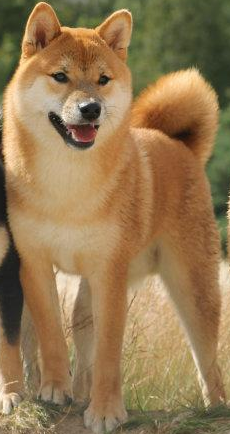

> dog: 0.9948
285 169 230 434


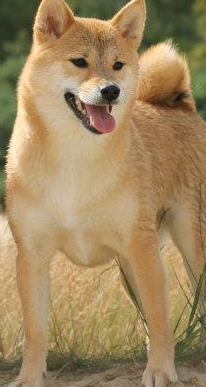

> dog: 0.9886
507 215 206 387


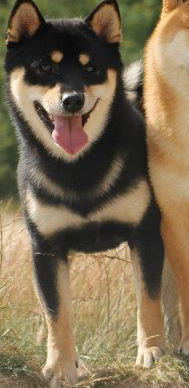

> dog: 0.9677
144 215 189 388


In [ ]:
# para garantir que vá executar apenas se existir pelo menos uma detecção
if len(objs) > 0:

    # percorre os indices de cada detecção da lista 
    for i in objs.flatten():
        # extrai as coordenadas da caixa de detecção
        (x, y) = (caixas[i][0], caixas[i][1]) # coordenada (x,y) onde inicia a caixa da detecção
        (w, h) = (caixas[i][2], caixas[i][3]) # largura e altura em pixels da caixa de detecção

        # com base nessas coordenadas, vamos mostrar em uma imagem separada apenas o objeto detectado   
        objeto = imagem_cp[y:y + h, x:x + w]
        # exibimos com base na cópia da imagem original (imagem_cp) ao invés da imagem original (imagem), pois a
        # original será modificada a cada iteração do for, e se for detectado mais de 1 objeto podem haver linhas
        # da caixa de detecção que sobreponham outro objeto caso os objetos detectados estejam muito proximos
        # (obs: isso é apenas pra visualização, pra ver se a detecção foi conforme esperado, na prática não muda)
        cv2_imshow(objeto)

        # define uma cor única para a classe
        cor = [int(c) for c in COLORS[IDclasses[i]]]

        # desenha o retangulo (caixa de detecçção) ao redor do objeto, com base nas coordenadas extraídas
        cv2.rectangle(imagem, (x, y), (x + w, y + h), cor, 2) 

        # vamos definir o texto da detecção, que será o nome da classe detectada
        # podemos colocar a confiança da predição ao lado do nome da classe
        texto = "{}: {:.4f}".format(LABELS[IDclasses[i]], confiancas[i])
        print("> " + texto)
        print(x,y,w,h)
        
        # escreve o texto em cima do retangulo (o label/nome do objeto e a confiança)
        cv2.putText(imagem, texto, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, cor, 2)

#print('Tempo: ' + str(termino - inicio))

Agora vamos mostrar o resultado

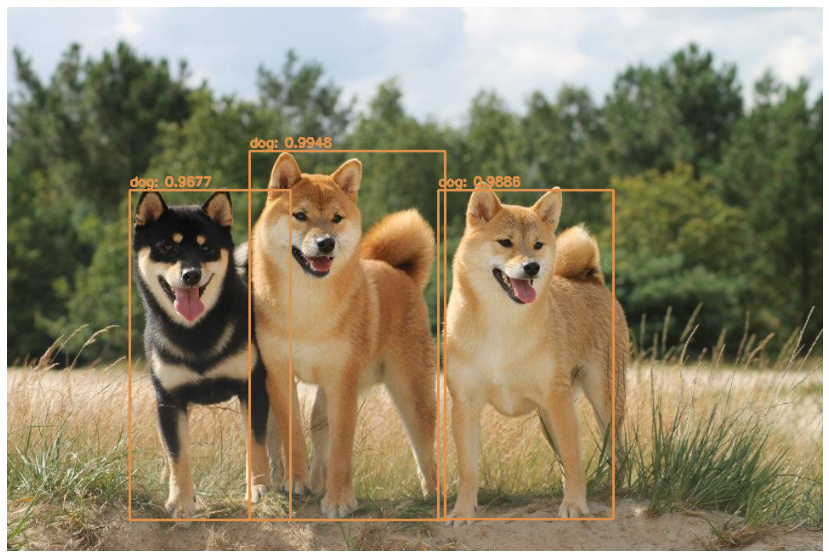

In [ ]:
mostrar(imagem)

Podemos salvar esse resultado da detecção em uma imagem utilizando a função `cv2.imwrite()`

In [ ]:
cv2.imwrite("resultado.jpg", imagem)

True

Se quiser também é possível baixar essa imagem para seu computador usando a função do próprio Colab abaixo (ou também da pra baixar clicando com o botão direito sobre o arquivo no painel lateral e selecionando Download)

In [ ]:
from google.colab import files

files.download('resultado.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ou também pode salvar a imagem diretamente no Drive

In [ ]:
!cp ./resultado.jpg /content/gdrive/My\ Drive/Cursos/YOLO/imagens/resultado.jpg